In [1]:
import numpy as np
import pandas as pd
import tempfile
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.simplefilter('ignore')
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from banditpylib.arms import BernoulliArm
from banditpylib.bandits import ThresholdingBandit
from banditpylib.protocols import SinglePlayerProtocol
from banditpylib.learners.thres_bandit_learners import APT, Uniform

In [2]:
def play_game(means, budget, eps=0.1, trials=5000):
  arms = [BernoulliArm(mean) for mean in means]
  theta = 0.5
  bandit = ThresholdingBandit(arms=arms, theta=theta, eps=eps)
  learners = [APT(arm_num=len(arms), budget=budget, theta=theta, eps=eps), 
              Uniform(arm_num=len(arms), budget=budget, theta=theta, eps=eps)]
  gap = 100
  # record intermediate regrets for each trial of a game
  intermediate_regrets = list(range(0, budget+1, gap))[1:]
  temp_file = tempfile.NamedTemporaryFile()
  
  # simulator
  game = SinglePlayerProtocol(bandit=bandit, learners=learners, intermediate_regrets=intermediate_regrets)
  # start playing the game
  # add `debug=True` for debugging purpose
  game.play(trials=trials, output_filename=temp_file.name)
  
  with open(temp_file.name, 'r') as f:
    data = []
    lines = f.readlines()
    for line in lines:
      data.append(json.loads(line))
    data_df = pd.DataFrame.from_dict(data)
  
  data_df = data_df.groupby(['learner', 'total_actions'])['regret'].mean().reset_index()
  data_df['regret'] = np.log(data_df['regret'])
  data_df = data_df.replace(float('nan'), 0)
  data_df.head()
  
  sns.lineplot(x='total_actions', y='regret', hue='learner', data=data_df)

INFO:absl:start apt's play with thresholding_bandit
INFO:absl:apt's play with thresholding_bandit runs 55.07 seconds.
INFO:absl:start uniform_sampling's play with thresholding_bandit
INFO:absl:uniform_sampling's play with thresholding_bandit runs 11.70 seconds.


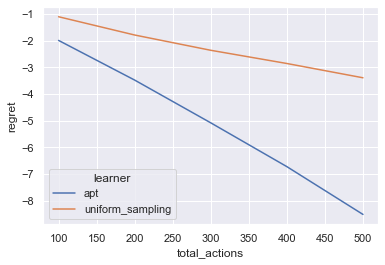

In [3]:
means=[0.1, 0.1, 0.1, 0.35, 0.45, 0.55, 0.65, 0.9, 0.9, 0.9]
play_game(means, 500)